<a href="https://colab.research.google.com/github/SebastianMM-96/fake-news/blob/add-license-1/fake-news/DataAnalysis/Data_analisys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de datos | Noticias reales ó falsas
#### Developed by: Sebastián Marroquín

***

### 1. Importando las librerias necesarias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
import string
from bs4 import BeautifulSoup
import re

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Importando los conjuntos de datos

In [2]:
print('Importando los conjuntos de datos...')
fake = pd.read_csv('/content/data/Fake.csv')
real = pd.read_csv('/content/data/True.csv')
print('Listo')

Importando los conjuntos de datos...
Listo


Mostraremos algunos elementos de los conjuntos de datos que recientemente hemos cargado

In [3]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Añadiremos una etiqueta a nuestros dataframe para poder identificar cual de ellos es falso ó verdadero

In [5]:
real['label'] = 0
fake['label'] = 1

Utilizaremos la función de concatenación para unir estos dos dataframes en uno solo y comenzar a analizarlo

In [6]:
data = pd.concat([real, fake])

Echaremos un vistazo a nuestro nuevo dataframe

In [7]:
data.sample(10)

,title,text,subject,date,label
11517,Legal action to see whether UK could unilatera...,EDINBURGH (Reuters) - A group of anti-Brexit S...,worldnews,"December 22, 2017",0
14952,Turkey's Erdogan says will discuss Syrian dial...,ANKARA (Reuters) - Turkish President Tayyip Er...,worldnews,"November 13, 2017",0
20292,YIKES! SHOCKING FOOTAGE Of Black Lives Matter ...,It s pretty safe to say if you stand in front ...,left-news,"Jul 12, 2016",1
18416,NYC COP Congratulates Trump Supporter For Educ...,"Based Stickman, aka Kyle Chapman became famous...",left-news,"Jun 29, 2017",1
6980,Separation anxiety: Trump’s management style p...,NEW YORK (Reuters) - It has proven one of Dona...,politicsNews,"December 1, 2016",0
20616,Bangladesh wants 'safe zones' to ease Rohingya...,DHAKA (Reuters) - Bangladesh has proposed crea...,worldnews,"September 8, 2017",0
14140,"Israeli veteran, government clash over alleged...",JERUSALEM (Reuters) - An Israeli ex-soldier wh...,worldnews,"November 22, 2017",0
15541,"U.S., Turkey restart issuing visas but tension...",ANKARA (Reuters) - The United States partially...,worldnews,"November 6, 2017",0
3166,U.S. rescinds Obama plan for some undocumented...,(Reuters) - U.S. Homeland Security Secretary J...,politicsNews,"June 16, 2017",0
8008,Trump tweets he raised $13 million in 24 hours...,WASHINGTON (Reuters) - Republican Party presid...,politicsNews,"September 27, 2016",0


Verificaremos si pueden existir valores en nulo

In [8]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

### 3. Visualización

Visualizaremos cuantas de las noticias que tenemos dentro de nuestro dataframe son reales y cuantas de ellas son falsas

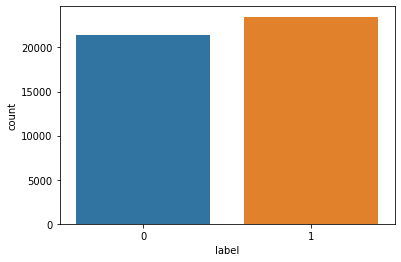

In [9]:
sns.countplot(data.label)

Los números parecen ser relativamente los mismos, ahora veremos cuantos de los títulos dentro de las noticias son únicos

In [10]:
print("Títulos únicos: {}".format(data.title.count()))

Títulos únicos: 44898


Visualizaremos cúantos tipos de noticias existen dentro del dataframe

In [11]:
data.subject.value_counts()

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

Ahora veremos cuantas de las noticias que tenemos dentro de nuestro conjunto de datos son de temas diferentes

[Text(0, 0, 'politicsNews'),
 Text(0, 0, 'worldnews'),
 Text(0, 0, 'News'),
 Text(0, 0, 'politics'),
 Text(0, 0, 'Government News'),
 Text(0, 0, 'left-news'),
 Text(0, 0, 'US_News'),
 Text(0, 0, 'Middle-east')]

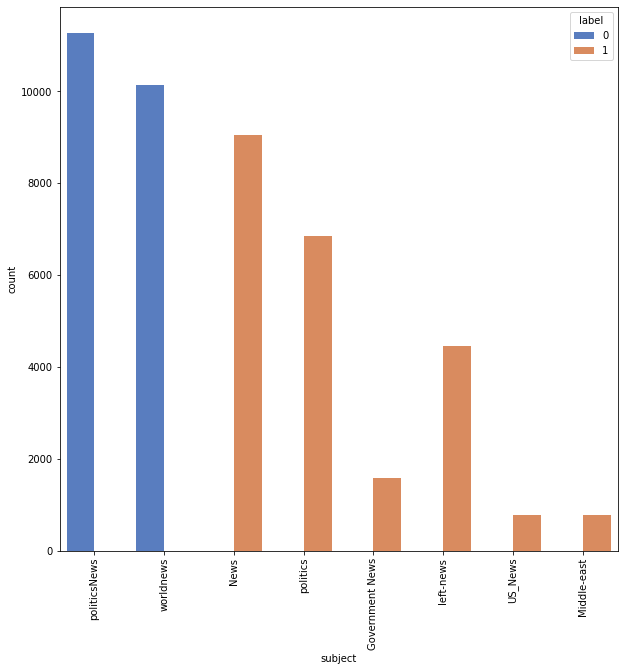

In [12]:
plt.figure(figsize=(10,10))
chart=sns.countplot(x='subject', hue='label', data=data, palette='muted')
chart.set_xticklabels(chart.get_xticklabels(),rotation=90,fontsize=10)

Ahora colocaremos todas las columnas requeridas en una y eliminaremos todas las columnas no tan requeridas.



In [13]:
data['text']= data['text']+ " " + data['title']
del data['title']
del data['subject']
del data['date']

Ahora nuestro conjunto de datos tiene la siguiente forma

In [14]:
data.head(10)

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,0
1,WASHINGTON (Reuters) - Transgender people will...,0
2,WASHINGTON (Reuters) - The special counsel inv...,0
3,WASHINGTON (Reuters) - Trump campaign adviser ...,0
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,0
5,"WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",0
6,"WEST PALM BEACH, Fla (Reuters) - President Don...",0
7,The following statements were posted to the ve...,0
8,The following statements were posted to the ve...,0
9,WASHINGTON (Reuters) - Alabama Secretary of St...,0


### 4. Limpieza de los datos

Nuestro conjunto de datos puede contener URL's, etiquetas de HTML que pueden llegar a dificultar que el modelo pueda realizar la predicción de manera correcta. Para que esto no suceda, debemos de limpiar el conjunto de datos para que los modelos que realizemos sean lo más eficiente posibles. 

Para hacer esto, removeremos lo siguiente:


1.   Puntuación
2.   Palabras vacías
3.   Etiquetas de HTML


#### 4.1 Librerías que utilizaremos



*   [beautifulsoup](https://pypi.org/project/beautifulsoup4/): Biblioteca para la extracción de información proveniente de páginas web. 

*   [re](https://docs.python.org/3/library/re.html): Realizar operaciones con expresiones regulares






In [15]:
stop_words = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

Definiremos las funciones para la limpieza de los datos (texto)

In [16]:
def string_html(text):
    soup=BeautifulSoup(text,"html.parser")
    return soup.get_text()

def remove_square_brackets(text):
    return re.sub('\[[^]]*\]','',text)

def remove_URL(text):
    return re.sub(r'http\S+','',text)

def remove_stopwords(text):
    final_text=[]
    for i in text.split():
        if i.strip().lower() not in stop_words:
            final_text.append(i.strip())
    return " ".join(final_text)

def clean_text_data(text):
    text=string_html(text)
    text=remove_square_brackets(text)
    text=remove_stopwords(text)
    text=remove_URL(text)
    return text

In [17]:
data['text'] = data['text'].apply(clean_text_data)

### 5. Palabras más frecuentes

Para la visualización de las palabras más frecuentes, utilizaremos la librería por excelencia: [wordcloud](https://pypi.org/project/wordcloud/). Esta librería es una técnica de visualización de datos que utilizaremos para representar datos de nuestro dataframe en los que el tamaño de cada palabra contenida dentro del texto de las noticias nos indicará su frecuencia o importancia (entre más grande, mayor es su importancia o frecuencia).

In [18]:
from wordcloud import STOPWORDS, WordCloud

#### 5.1 Palabras más frecuentes | Noticias falsas

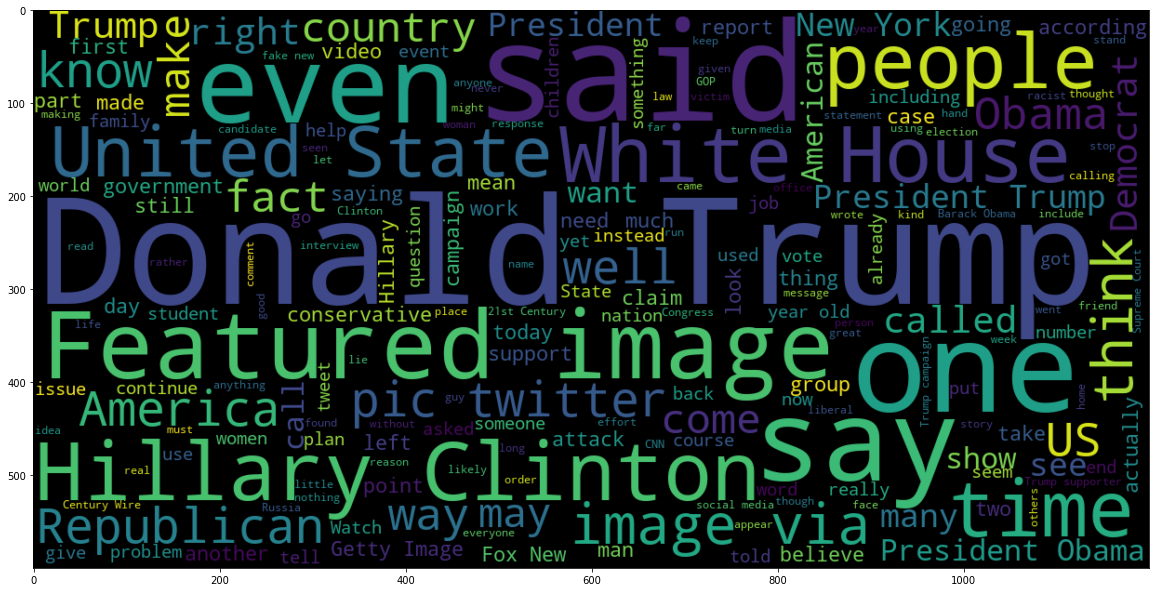

In [19]:
plt.figure(figsize=(20,20))
wordcloud=WordCloud(stopwords=STOPWORDS,height=600,width=1200).generate(" ".join(data[data.label==1].text))
plt.imshow(wordcloud,interpolation='bilinear')

#### 5.2 Palabras más frecuentes | Noticias reales

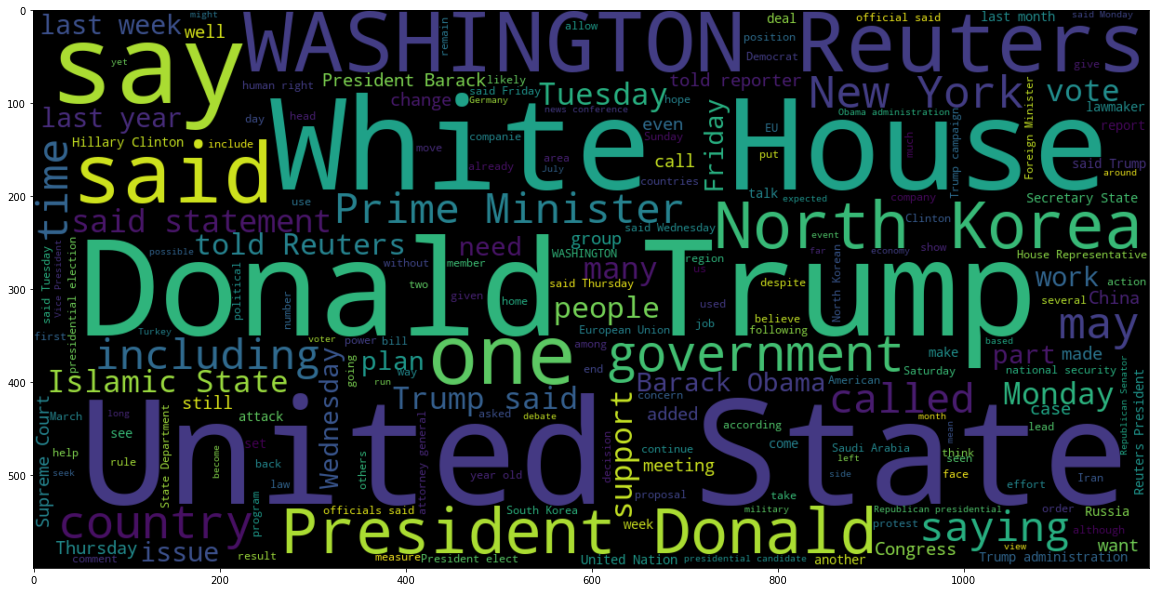

In [20]:
plt.figure(figsize=(20,20))
wordcloud=WordCloud(stopwords=STOPWORDS,height=600,width=1200).generate(" ".join(data[data.label == 0].text))
plt.imshow(wordcloud,interpolation='bilinear')